In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches
from typing import List, Optional, Tuple

import torch
import hydra
import pyrootutils
import pytorch_lightning as pl
from omegaconf import DictConfig
from pytorch_lightning import (Callback, LightningDataModule, LightningModule,
                               Trainer)
from pytorch_lightning.loggers import TensorBoardLogger

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils

log = utils.get_pylogger(__name__)

torch.set_float32_matmul_precision('medium')
# torch.autograd.set_detect_anomaly(True)

from src.models.simclr import SimCLR

from src.models.unet3d.model_encoders import UNet3D as UNet3D_Encoder


import SimpleITK as sitk

sitk.ProcessObject_SetGlobalWarningDisplay(False)
test_path = '/mrhome/vladyslavz/Pictures/test_imgs'

In [2]:
CHKP = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs_finetuning/CS1x_noSST_MSELoss_RegressionUnet-fullFinetune/runs/2023-04-17_16-40-37/checkpoints/epoch-008-val_mse-0.0007.ckpt'

In [3]:
CHKP = Path(CHKP)
NAME = CHKP.parent.parent.parent.parent.name
cgf_path = CHKP.parent.parent / '.hydra' / 'config.yaml'
segm_cfg = OmegaConf.load(cgf_path)


In [4]:

# segm_cfg.model.encoder_chkp = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs_sst/synthseg-monai-BasicUnet-1.5x-half/runs/2023-04-13_16-13-49/checkpoints/epoch-251_val_loss-0.000.ckpt'
segm_datamodule: LightningDataModule = hydra.utils.instantiate(segm_cfg.data)

segm_model: LightningModule = hydra.utils.instantiate(segm_cfg.model,
                                                      freeze_encoder=True,
                                                      monai=True)

print(segm_cfg.data)

2023-04-18 09:31:25,437 - Len of train examples 38 len of validation examples 12
Freezing encoder...
{'_target_': 'src.data.bvisa_augm_dm.CS_DataModule', 'dataset_cfg': {'dataset': 'bvisa', 'target': 'central_sulcus', 'dataset_path': '/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa_augm/nobackup/generated', 'use_half_brain': False, 'resample': None, 'crop2content': False, 'padd2same_size': '256-256-124', 'regresssion': 'distance-transform'}, 'train_batch_size': 1, 'validation_batch_size': 1, 'num_workers': 0, 'double_validation': True}


Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.


In [5]:
segm_model = segm_model.load_from_checkpoint(CHKP,
                                             freeze_encoder=False,
                                             monai=True)

In [6]:
idx = 0

val_sample = segm_datamodule.orig_val_dataset[idx]

img = val_sample['image']
target = val_sample['target']
caseid = val_sample['caseid']
sitk_img = sitk.ReadImage(segm_datamodule.orig_val_dataset.img_paths[idx][0])



In [7]:
with torch.no_grad():
    segm_pred = segm_model(img.unsqueeze(0))

In [16]:
# segm_pred = segm_pred.to('cpu').squeeze(0).squeeze(0).numpy()
# segm_pred = (segm_pred - segm_pred.min()) / (segm_pred.max() - segm_pred.min())
# segm_pred_bin = segm_pred

In [17]:
# segm_pred_bin = torch.softmax(segm_pred, dim=1)[:,0,:,:,:].squeeze(0).squeeze(0).numpy()
# segm_pred_bin = np.logical_not(segm_pred_bin > 0.5).astype(np.int16)
segm_pred_sitk = sitk.GetImageFromArray(segm_pred_bin)
# target_img = sitk.GetImageFromArray(target.numpy().astype(np.uint8))

segm_pred_sitk.CopyInformation(sitk_img)
# target_img.CopyInformation(sitk_img)

In [ ]:
sitk_img = sitk.GetImageFromArray(img[0].numpy().astype(np.float32))

In [ ]:
sitk.GetArrayFromImage(segm_pred_sitk).max()

1

In [ ]:
sitk.WriteImage(segm_pred_sitk, f'{test_path}/pred_{NAME}.nii.gz')
sitk.WriteImage(sitk_img, f'{test_path}/img_{NAME}.nii.gz')
sitk.WriteImage(target_img, f'{test_path}/target_{NAME}.nii.gz')

In [18]:
sitk.WriteImage(segm_pred_sitk, f'{test_path}/pred_{NAME}.nii.gz')


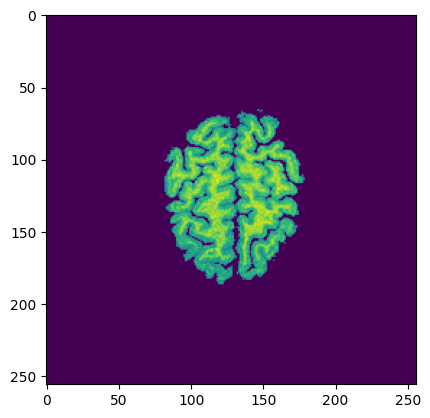

In [26]:
plt.imshow(img[0, 90, :, :].numpy())

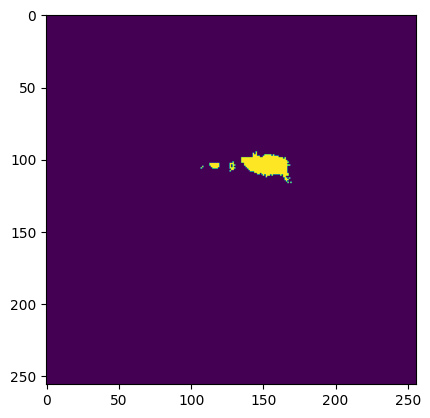

In [31]:
plt.imshow(segm_pred_bin[90,:,:]>0.4)